# **_03_real_world_data_to_tensors**

---------------------------------------------------

In [21]:
import os
import imageio.v2 as imageio
import torch

# a_2d_image_data

In [22]:
img_arr = imageio.imread(os.path.join(os.path.pardir, os.path.pardir, "_00_data", "a_image-dog", "bobby.jpg"))
print(type(img_arr))
print(img_arr.shape)
print(img_arr.dtype)

<class 'imageio.core.util.Array'>
(720, 1280, 3)
uint8


In [133]:
img = torch.from_numpy(img_arr) # numpy 배열로 변환
out = img.permute(2, 0, 1) # 텐서 차원 재배열 (high, width, rgb채널수) -> (rgb채널수, high, width)
print(out.shape)

torch.Size([3, 256, 256])


In [24]:
data_dir = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "b_image-cats")
filenames = [
  name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png'
]
print(filenames)

['cat1.png', 'cat2.png', 'cat3.png']


In [25]:
from PIL import Image

In [134]:
for i, filename in enumerate(filenames):
    image = Image.open(os.path.join(data_dir, filename))
    image.show()
    #img_arr = imageio.imread(os.path.join(data_dir, filename))
    #print(img_arr.shape)
    #print(img_arr.dtype)

- enumerate를 사용하여 파일의 인덱스와 파일 이름을 순회
- image.show(): 열린 이미지를 화면에 표시함. 이를 통해 이미지 뷰어가 사용자에게 이미지를 표시함

In [27]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 256, 256, dtype=torch.uint8)

In [28]:
for i, filename in enumerate(filenames):
    img_arr = imageio.imread(os.path.join(data_dir, filename))
    img_t = torch.from_numpy(img_arr)
    img_t = img_t.permute(2, 0, 1)
    img_t = img_t[:3]
    batch[i] = img_t

print(batch.shape)

torch.Size([3, 3, 256, 256])


In [29]:
batch = batch.float()
batch /= 255.0
print(batch.dtype)
print(batch.shape)

torch.float32
torch.Size([3, 3, 256, 256])


In [30]:
n_channels = batch.shape[1]

In [31]:
for c in range(n_channels):
    mean = torch.mean(batch[:, c])
    std = torch.std(batch[:, c])
    batch[:, c] = (batch[:, c] - mean) / std

# b_3d_image_data

In [32]:
import imageio.v2 as imageio

In [33]:
dir_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "c_volumetric-dicom", "2-LUNG_3.0_B70f-04083")
vol_array = imageio.volread(dir_path, format='DICOM')
print(type(vol_array))
print(vol_array.shape)
print(vol_array.dtype)
print(vol_array[0])

Reading DICOM (examining files): 1/99 files (1.0%99/99 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 99/99  (100.0%)
<class 'imageio.core.util.Array'>
(99, 512, 512)
int16
[[ -985  -990  -999 ... -1017 -1008  -971]
 [-1016  -984  -963 ... -1000 -1009  -999]
 [-1024 -1008  -996 ...  -979 -1021  -987]
 ...
 [ -920  -942  -944 ...  -893  -917  -955]
 [ -871  -879  -905 ...  -895  -869  -867]
 [ -876  -855  -873 ...  -933  -982  -936]]


In [34]:
import matplotlib.pyplot as plt

- matplotlib.pyplot를 사용하여 데이터를 시각화.

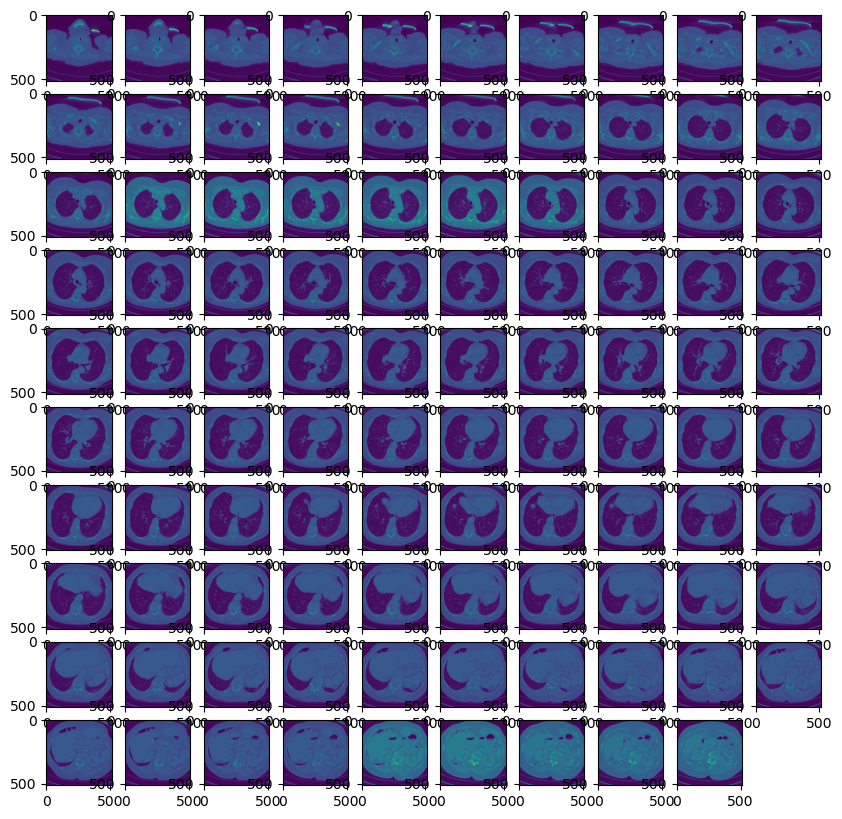

In [35]:
# 99개의 슬라이스를 10x10 그리드로 표시
fig = plt.figure(figsize=(10, 10))
for id in range(0, 99):
    fig.add_subplot(10, 10, id + 1)
    plt.imshow(vol_array[id])
plt.show()

In [36]:
# torch.unsqueeze(vol, 0): 차원을 추가하여 데이터 크기를 변경. 
# 두 번의 차원 추가를 통해 데이터를 (1, 1, 99, 512, 512) 형태로 변경
vol = torch.from_numpy(vol_array).float()
vol = torch.unsqueeze(vol, 0)  # channel
vol = torch.unsqueeze(vol, 0)  # data size

print(vol.shape)

torch.Size([1, 1, 99, 512, 512])


In [37]:
# keepdim=True를 사용하여 결과 텐서에도 해당 차원을 유지하도록 지정
mean = torch.mean(vol, dim=(3, 4), keepdim=True) # 평균
print(mean.shape)
std = torch.std(vol, dim=(3, 4), keepdim=True) # 표준편차
print(std.shape)
vol = (vol - mean) / std # 정규화된 데이터를 생성
print(vol.shape)

torch.Size([1, 1, 99, 1, 1])
torch.Size([1, 1, 99, 1, 1])
torch.Size([1, 1, 99, 512, 512])


- mean -> 결과 텐서의 형태는 [batch_size, channels, slices, 1, 1]이 됨
- std -> 결과 텐서의 형태는 [batch_size, channels, slices, 1, 1]이 됨

In [38]:
print(vol[0, 0, 0])

tensor([[-1.0002, -1.0102, -1.0283,  ..., -1.0645, -1.0464, -0.9720],
        [-1.0625, -0.9982, -0.9560,  ..., -1.0303, -1.0484, -1.0283],
        [-1.0785, -1.0464, -1.0223,  ..., -0.9881, -1.0725, -1.0042],
        ...,
        [-0.8696, -0.9138, -0.9178,  ..., -0.8153, -0.8636, -0.9399],
        [-0.7711, -0.7872, -0.8394,  ..., -0.8194, -0.7671, -0.7631],
        [-0.7812, -0.7390, -0.7752,  ..., -0.8957, -0.9941, -0.9017]])


# c_tabular_wine_data

In [140]:
import csv
import os
import numpy as np
import torch

In [141]:
wine_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "d_tabular-wine", "winequality-white.csv")
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)
print(wineq_numpy.dtype)
print(wineq_numpy.shape) # (4898, 12) 
print(wineq_numpy)

float32
(4898, 12)
[[ 7.    0.27  0.36 ...  0.45  8.8   6.  ]
 [ 6.3   0.3   0.34 ...  0.49  9.5   6.  ]
 [ 8.1   0.28  0.4  ...  0.44 10.1   6.  ]
 ...
 [ 6.5   0.24  0.19 ...  0.46  9.4   6.  ]
 [ 5.5   0.29  0.3  ...  0.38 12.8   7.  ]
 [ 6.    0.21  0.38 ...  0.32 11.8   6.  ]]


- np.loadtxt() 함수를 사용하여 CSV 파일을 로드
- dtype=np.float32: 데이터의 타입을 32비트 부동 소수점(float32)으로 설정
- delimiter=";": CSV 파일의 구분자(delimiter)를 세미콜론(;)으로 설정
- skiprows=1: 파일의 첫 번째 행은 헤더(열 이름)이므로 스킵하고 데이터 로드를 시작

In [142]:
col_list = next(csv.reader(open(wine_path), delimiter=';'))
print(col_list)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


- next() 함수 : 다음 행을 읽는다. CSV 파일의 첫 번째 행, 즉 헤더(열 이름)를 읽게 된다.

In [143]:
wineq = torch.from_numpy(wineq_numpy)
print(wineq.dtype)
print(wineq.shape)

torch.float32
torch.Size([4898, 12])


In [144]:
data = wineq[:, :-1]  # 모든 행에 대해서 마지막 열을 제외한 모든 열을 선택
print(data.dtype)
print(data.shape)
print(data)

torch.float32
torch.Size([4898, 11])
tensor([[ 7.0000,  0.2700,  ...,  0.4500,  8.8000],
        [ 6.3000,  0.3000,  ...,  0.4900,  9.5000],
        ...,
        [ 5.5000,  0.2900,  ...,  0.3800, 12.8000],
        [ 6.0000,  0.2100,  ...,  0.3200, 11.8000]])


In [145]:
target = wineq[:, -1]  # 모든 행에 대해서 마지막 열만 선택
print(target.dtype)
print(target.shape)
print(target)

torch.float32
torch.Size([4898])
tensor([6., 6.,  ..., 7., 6.])


In [146]:
target = target.long()  
print(target.dtype)
print(target.shape)
print(target)

torch.int64
torch.Size([4898])
tensor([6, 6,  ..., 7, 6])


In [147]:
eye_matrix = torch.eye(10) # 10 by 10 단위행렬
# 'target' 텐서를 사용하여 항등 행렬에서 해당하는 행을 추출합니다
# 이 작업은 'target' 텐서의 각 요소에 대한 원-핫 벡터를 생성할 수 있습니다
onehot_target = eye_matrix[target] # advanced encoding

In [148]:
print(onehot_target[0])
print(onehot_target[1])
print(onehot_target[-2])
print(onehot_target)

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([[0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.],
        ...,
        [0., 0.,  ..., 0., 0.],
        [0., 0.,  ..., 0., 0.]])


In [149]:
# 정규화
data_mean = torch.mean(data, dim=0)
data_var = torch.var(data, dim=0)
data = (data - data_mean) / torch.sqrt(data_var)
print(data)

tensor([[ 1.7208e-01, -8.1761e-02,  ..., -3.4915e-01, -1.3930e+00],
        [-6.5743e-01,  2.1587e-01,  ...,  1.3422e-03, -8.2419e-01],
        ...,
        [-1.6054e+00,  1.1666e-01,  ..., -9.6251e-01,  1.8574e+00],
        [-1.0129e+00, -6.7703e-01,  ..., -1.4882e+00,  1.0448e+00]])


In [49]:
from sklearn.model_selection import train_test_split

- 데이터를 훈련 세트와 테스트 세트로 분할하기 위해 사용

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(data, onehot_target, test_size=0.2)

- data: 특성 데이터, 모델의 입력으로 사용
- onehot_target: 원-핫 인코딩된 타겟 데이터, 모델의 실제 예측 대상
- X_train: 훈련 데이터의 특성 (80%의 데이터)
- X_valid: 검증 데이터의 특성 (20%의 데이터)
- y_train: 훈련 데이터의 타겟 (80%의 데이터)
- y_valid: 검증 데이터의 타겟 (20%의 데이터)

In [51]:
print(X_train.shape)
print(y_train.shape)

torch.Size([3918, 11])
torch.Size([3918, 10])


In [52]:
print(X_valid.shape)
print(y_valid.shape)

torch.Size([980, 11])
torch.Size([980, 10])


In [151]:
def get_wine_data():
    wine_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "d_tabular-wine", "winequality-white.csv")
    wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)

    wineq = torch.from_numpy(wineq_numpy)

    data = wineq[:, :-1]  # Selects all rows and all columns except the last
    target = wineq[:, -1].long()  # treat labels as an integer

    # eye_matrix에는 원-핫 벡터들이 행렬 형태로 저장되어 있으며, target을 인덱스로 사용하여 각 샘플에 해당하는 원-핫 벡터를 선택
    eye_matrix = torch.eye(10)
    onehot_target = eye_matrix[target]

    data_mean = torch.mean(data, dim=0)
    data_var = torch.var(data, dim=0)
    data = (data - data_mean) / torch.sqrt(data_var)

    X_train, X_valid, y_train, y_valid = train_test_split(data, onehot_target, test_size=0.2)

    return X_train, X_valid, y_train, y_valid

#get_wine_data()

# d_tabular_california_housing

In [152]:
import torch
from sklearn.datasets import fetch_california_housing

In [153]:
housing = fetch_california_housing()
print(housing.keys())

dict_keys(['data', 'target', 'frame', 'target_names', 'feature_names', 'DESCR'])


In [154]:
print(type(housing.data))
print(housing.data.dtype)
print(housing.data.shape)
print(housing.feature_names)

<class 'numpy.ndarray'>
float64
(20640, 8)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [57]:
print(housing.target.shape)
print(housing.target_names)

(20640,)
['MedHouseVal']


In [58]:
import numpy as np

In [59]:
print(housing.data.min(), housing.data.max())

-124.35 35682.0


In [60]:
data_mean = np.mean(housing.data, axis=0)
data_var = np.var(housing.data, axis=0)
data = (housing.data - data_mean) / np.sqrt(data_var)
target = housing.target

- np.mean() 함수를 사용하여 특성 데이터의 평균(data_mean)을 계산. axis=0을 지정하면 각 열(특성)에 대한 평균을 계산.

- np.var() 함수를 사용하여 특성 데이터의 분산(data_var)을 계산. 마찬가지로 axis=0을 지정하여 각 열(특성)에 대한 분산을 계산.

- 표준화(Standardization) 작업을 수행. 표준화는 각 특성의 평균을 빼고, 그 결과를 해당 특성의 표준 편차로 나누는 과정으로, 데이터의 스케일을 조정하는 데 사용됨. (housing.data - data_mean) / np.sqrt(data_var) 식을 사용하여 모든 특성을 표준화.

- 타겟 데이터를 housing.target에서 추출합니다.

In [61]:
print(data.min(), data.max())

-2.3859923416733877 119.41910318829312


In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2)

In [64]:
X_train = torch.from_numpy(X_train)
X_valid = torch.from_numpy(X_valid)
y_train = torch.from_numpy(y_train)
y_valid = torch.from_numpy(y_valid)

In [65]:
print(X_train.shape)
print(y_train.shape)

torch.Size([16512, 8])
torch.Size([16512])


In [66]:
print(X_valid.shape)
print(y_valid.shape)

torch.Size([4128, 8])
torch.Size([4128])


# e_time_series_data

In [67]:
import os
import numpy as np
import torch

In [68]:
torch.set_printoptions(edgeitems=2, threshold=50, linewidth=75)

In [69]:
bikes_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "e_time-series-bike-sharing-dataset", "hour-fixed.csv")

In [70]:
bikes_numpy = np.loadtxt(
    fname=bikes_path, dtype=np.float32, delimiter=",", skiprows=1,
    converters={
        1: lambda x: float(x[8:10])  # 2011-01-07 --> 07 --> 7
    }
)
bikes = torch.from_numpy(bikes_numpy)
print(bikes.shape)
print(bikes)

torch.Size([17520, 17])
tensor([[1.0000e+00, 1.0000e+00,  ..., 1.3000e+01, 1.6000e+01],
        [2.0000e+00, 1.0000e+00,  ..., 3.2000e+01, 4.0000e+01],
        ...,
        [1.7378e+04, 3.1000e+01,  ..., 4.8000e+01, 6.1000e+01],
        [1.7379e+04, 3.1000e+01,  ..., 3.7000e+01, 4.9000e+01]])


- converters={1: lambda x: float(x[8:10])}: converters는 데이터를 변환하는 데 사용할 함수를 지정하는 딕셔너리이다. 
- 여기서는 람다 함수(lambda)를 사용하여 데이터의 두 번째 열(인덱스 1)에 대한 변환 함수를 정의한다.
- 이 함수는 문자열에서 숫자로 변환하기 위해 날짜 문자열에서 8번째부터 10번째 글자를 추출하고, 이를 float로 변환한다. 즉, "2011-01-07"과 같은 날짜 문자열에서 "07"을 추출하여 7로 변환한다.

In [71]:
daily_bikes = bikes.view(-1, 24, bikes.shape[1])
print(daily_bikes.shape)  # torch.Size([730, 24, 17])

torch.Size([730, 24, 17])


In [72]:
daily_bikes_data = daily_bikes[:, :, :-1]
daily_bikes_target = daily_bikes[:, :, -1].unsqueeze(dim=-1)

In [73]:
print(daily_bikes_data.shape)
print(daily_bikes_target.shape)

torch.Size([730, 24, 16])
torch.Size([730, 24, 1])


In [74]:
first_day_data = daily_bikes_data[0]
print(first_day_data.shape)

torch.Size([24, 16])


In [75]:
print(first_day_data[:, 9].long())
eye_matrix = torch.eye(4)
print(eye_matrix)

tensor([1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2,
        2, 2])
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In [76]:
weather_onehot = eye_matrix[first_day_data[:, 9].long() - 1]
print(weather_onehot.shape)
print(weather_onehot)

torch.Size([24, 4])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])


In [77]:
first_day_data_torch = torch.cat(tensors=(first_day_data, weather_onehot), dim=1)
print(first_day_data_torch.shape)
print(first_day_data_torch)

torch.Size([24, 20])
tensor([[ 1.,  1.,  ...,  0.,  0.],
        [ 2.,  1.,  ...,  0.,  0.],
        ...,
        [23.,  1.,  ...,  0.,  0.],
        [24.,  1.,  ...,  0.,  0.]])


In [78]:
day_data_torch_list = []
for daily_idx in range(daily_bikes_data.shape[0]):  # range(730)
    day = daily_bikes_data[daily_idx]  # day.shape: [24, 17]
    weather_onehot = eye_matrix[day[:, 9].long() - 1] # 날씨 원-핫 인코딩
    day_data_torch = torch.cat(tensors=(day, weather_onehot), dim=1)  # day_torch.shape: [24, 21]
    day_data_torch_list.append(day_data_torch)

- 날씨 원-핫 인코딩: day 배열에서 날씨 정보를 추출하고, eye_matrix를 사용하여 해당 날씨를 원-핫 인코딩한다. 
- 날씨 정보는 day[:, 9]에서 추출되며, .long()을 사용하여 정수로 변환하고 1을 뺌(인덱스는 0부터 시작하므로). 

In [79]:
print(len(day_data_torch_list))
daily_bikes_data = torch.stack(day_data_torch_list, dim=0)
print(daily_bikes_data.shape)

730
torch.Size([730, 24, 20])


In [80]:
print(daily_bikes_data[:, :, :9].shape, daily_bikes_data[:, :, 10:].shape)
daily_bikes_data = torch.cat(
  [daily_bikes_data[:, :, :9], daily_bikes_data[:, :, 10:]],
  dim=2
)
print(daily_bikes_data.shape)

torch.Size([730, 24, 9]) torch.Size([730, 24, 10])
torch.Size([730, 24, 19])


In [81]:
temperatures = daily_bikes_data[:, :, 9]
daily_bikes_data[:, :, 9] = (daily_bikes_data[:, :, 9] - torch.mean(temperatures)) / torch.std(temperatures)

In [82]:
daily_bikes_data = daily_bikes_data.transpose(1, 2)
print(daily_bikes_data.shape)  # >>> torch.Size([730, 17, 24])

torch.Size([730, 19, 24])


# f_audio_data

In [156]:
import torch
import os
import scipy.io.wavfile as wavfile

In [157]:
audio_1_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "f_audio-chirp", "1-100038-A-14.wav")
audio_2_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "f_audio-chirp", "1-100210-A-36.wav")

In [158]:
freq_1, waveform_arr_1 = wavfile.read(audio_1_path)
print(freq_1)
print(type(waveform_arr_1))
print(len(waveform_arr_1))
print(waveform_arr_1)

44100
<class 'numpy.ndarray'>
220500
[ -388 -3387 -4634 ...  2289  1327    90]


In [86]:
freq_2, waveform_arr_2 = wavfile.read(audio_2_path)

In [87]:
waveform = torch.empty(2, 1, 220_500)
waveform[0, 0] = torch.from_numpy(waveform_arr_1).float()
waveform[1, 0] = torch.from_numpy(waveform_arr_2).float()
print(waveform.shape)

torch.Size([2, 1, 220500])


In [88]:
from scipy import signal

In [89]:
_, _, sp_arr_1 = signal.spectrogram(waveform_arr_1, freq_1)
_, _, sp_arr_2 = signal.spectrogram(waveform_arr_2, freq_2)

In [90]:
sp_1 = torch.from_numpy(sp_arr_1)
sp_2 = torch.from_numpy(sp_arr_2)
print(sp_1.shape)
print(sp_2.shape)

torch.Size([129, 984])
torch.Size([129, 984])


In [91]:
sp_left_t = torch.from_numpy(sp_arr_1)
sp_right_t = torch.from_numpy(sp_arr_2)
print(sp_left_t.shape)
print(sp_right_t.shape)

torch.Size([129, 984])
torch.Size([129, 984])


In [92]:
sp_t = torch.stack((sp_left_t, sp_right_t), dim=0).unsqueeze(dim=0)
print(sp_t.shape)

torch.Size([1, 2, 129, 984])


# g_video_data

In [99]:
import torch
import os
import imageio 

In [102]:
pip install imageio[ffmpeg]

  Obtaining dependency information for imageio-ffmpeg from https://files.pythonhosted.org/packages/c6/01/716106099e48c4f419876d5814679a94dd7d6f441217c97c1b608123c6bb/imageio_ffmpeg-0.4.9-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/22.6 MB ? eta -:--:--
   ---------------------------------------- 0.2/22.6 MB 6.9 MB/s eta 0:00:04
    --------------------------------------- 0.4/22.6 MB 5.4 MB/s eta 0:00:05
   - -------------------------------------- 0.7/22.6 MB 5.2 MB/s eta 0:00:05
   - -------------------------------------- 0.9/22.6 MB 5.2 MB/s eta 0:00:05
   -- ------------------------------------- 1.2/22.6 MB 5.3 MB/s eta 0:00:05
   -- ------------------------------------- 1.4/22.6 MB 5.1 MB/s eta 0:00:05
   -- ------------------------------------- 1.6/22.6 MB 5.2 MB/s eta 0:00:05
   --- ------------------------------------ 1.9/22.6 MB 5.1 MB/s eta 0:00:05
   --- ------------------------------------ 2.0/22.6 MB 5.0 MB/s eta 0:00:05
   ---- ----------

In [103]:
video_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "g_video-cockatoo", "cockatoo.mp4")

In [104]:
reader = imageio.get_reader(video_path)
print(type(reader))
meta = reader.get_meta_data()
print(meta)

<class 'imageio.plugins.ffmpeg.FfmpegFormat.Reader'>
{'plugin': 'ffmpeg', 'nframes': inf, 'ffmpeg_version': '4.2.2 built with gcc 9.2.1 (GCC) 20200122', 'codec': 'h264', 'pix_fmt': 'yuv420p(tv, bt709)', 'audio_codec': 'aac', 'fps': 29.53, 'source_size': (480, 360), 'size': (480, 360), 'rotate': 0, 'duration': 17.93}


In [105]:
n_channels = 3
n_frames = 529
video = torch.empty(n_channels, n_frames, *meta['size'])
print(video.shape)

torch.Size([3, 529, 480, 360])


In [106]:
for i, frame in enumerate(reader):
    frame = torch.from_numpy(frame).float()  # frame.shape: [360, 480, 3]
    video[:, i] = torch.transpose(frame, 0, 2)

In [107]:
video = video.unsqueeze(dim=0)
print(video.shape)

torch.Size([1, 3, 529, 480, 360])


# h_linear_regression_dataset_dataloader

In [159]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [174]:
class LinearRegressionDataset(Dataset):
    def __init__(self, N=50, m=-3, b=2, *args, **kwargs):
        # N: 생성할 샘플(데이터 포인트)의 수
        # m: 선형 관계의 기울기(slope)
        # b: 선형 관계의 y 절편(offset)
        super().__init__(*args, **kwargs)

        self.x = torch.rand(N, 2)
        self.noise = torch.rand(N) * 0.2 #  선형 관계 모델에 약간의 noise을 추가하기 위해 사용
        self.m = m
        self.b = b
        self.y = (torch.sum(self.x * self.m) + self.b + self.noise).unsqueeze(-1)
        
    #  데이터셋의 길이를 반환    
    def __len__(self):
        return len(self.x)
    
    # 주어진 인덱스 idx에 해당하는 데이터 샘플을 반환
    def __getitem__(self, idx):
        return {'input': self.x[idx], 'target': self.y[idx]}
    
    # 데이터셋에 대한 정보를 문자열로 표시하는 역할
    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(len(self.x), self.x.shape, self.y.shape)
        return str

In [161]:
if __name__ == "__main__":
    linear_regression_dataset = LinearRegressionDataset()

    print(linear_regression_dataset)

    for idx, sample in enumerate(linear_regression_dataset):
        print("{0} - {1}: {2}".format(idx, sample['input'], sample['target']))

    train_dataset, validation_dataset, test_dataset = random_split(linear_regression_dataset, [0.7, 0.2, 0.1])

    print(len(train_dataset), len(validation_dataset), len(test_dataset))

    train_data_loader = DataLoader(
        dataset=train_dataset,
        batch_size=4,
        shuffle=True
    )
    
    for idx, batch in enumerate(train_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'], batch['target']))

Data Size: 50, Input Shape: torch.Size([50, 2]), Target Shape: torch.Size([50, 1])
0 - tensor([0.9943, 0.2241]): tensor([-153.3454])
1 - tensor([0.3809, 0.8938]): tensor([-153.4988])
2 - tensor([0.4710, 0.1599]): tensor([-153.4028])
3 - tensor([0.8740, 0.9555]): tensor([-153.3636])
4 - tensor([0.2508, 0.3434]): tensor([-153.3552])
5 - tensor([0.7552, 0.3669]): tensor([-153.3993])
6 - tensor([0.7943, 0.5131]): tensor([-153.3241])
7 - tensor([0.4034, 0.6248]): tensor([-153.3917])
8 - tensor([0.9895, 0.9270]): tensor([-153.3960])
9 - tensor([0.0861, 0.3031]): tensor([-153.4043])
10 - tensor([0.4579, 0.7234]): tensor([-153.3529])
11 - tensor([0.5236, 0.3802]): tensor([-153.4665])
12 - tensor([0.8728, 0.0353]): tensor([-153.3584])
13 - tensor([0.3179, 0.7225]): tensor([-153.3577])
14 - tensor([0.4846, 0.4181]): tensor([-153.3198])
15 - tensor([0.9009, 0.1285]): tensor([-153.4810])
16 - tensor([0.4619, 0.2489]): tensor([-153.5014])
17 - tensor([0.9876, 0.1881]): tensor([-153.4537])
18 - tens

#### if __name__ == "__main__" 의 역할
- 임포트된 경우가 아니라 인터프리터에서 직접 실행된 경우에만, if문 이하의 코드를 돌리라는 명령이다.
- 인터프리터에서 직접 실행하면, __name__ 변수에 "__main__" 이 담김
- 모듈에서 임포트해서 실행하면, __name__ 변수에 "executeThisModule"이 담김

# i_2d_image_dataset_dataloader

In [162]:
import os

import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

In [163]:
class DogCat2DImageDataset(Dataset):
    def __init__(self):
        self.image_transforms = transforms.Compose([
          transforms.Resize(size=(256, 256)),
          transforms.ToTensor()
        ])

        dogs_dir = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "a_image-dog")
        cats_dir = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "b_image-cats")

        image_lst = [
          Image.open(os.path.join(dogs_dir, "bobby.jpg")),  # (1280, 720, 3)
          Image.open(os.path.join(cats_dir, "cat1.png")),  # (256, 256, 3)
          Image.open(os.path.join(cats_dir, "cat2.png")),  # (256, 256, 3)
          Image.open(os.path.join(cats_dir, "cat3.png"))  # (256, 256, 3)
        ]

        image_lst = [self.image_transforms(img) for img in image_lst]
        self.images = torch.stack(image_lst, dim=0)

        # 0: "dog", 1: "cat"
        self.image_labels = torch.tensor([[0], [1], [1], [1]]) # 4개의 이미지에 대한 레이블을 정의

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {'input': self.images[idx], 'target': self.image_labels[idx]}

    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
          len(self.images), self.images.shape, self.image_labels.shape
        )
        return str

In [175]:
if __name__ == "__main__":
    dog_cat_2d_image_dataset = DogCat2DImageDataset()

    print(dog_cat_2d_image_dataset)

    print("#" * 50, 1)

    for idx, sample in enumerate(dog_cat_2d_image_dataset):
        print("{0} - {1}: {2}".format(idx, sample['input'].shape, sample['target']))

    # 훈련 데이터셋 : 70%
    # 테스트 데이터셋 : 30%
    train_dataset, test_dataset = random_split(dog_cat_2d_image_dataset, [0.7, 0.3])

    print("#" * 50, 2)

    print(len(train_dataset), len(test_dataset))

    print("#" * 50, 3)

    train_data_loader = DataLoader(
    dataset=train_dataset,
    batch_size=2,
    shuffle=True
    )

    for idx, batch in enumerate(train_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target']))

Data Size: 4, Input Shape: torch.Size([4, 3, 256, 256]), Target Shape: torch.Size([4, 1])
################################################## 1
0 - torch.Size([3, 256, 256]): tensor([0])
1 - torch.Size([3, 256, 256]): tensor([1])
2 - torch.Size([3, 256, 256]): tensor([1])
3 - torch.Size([3, 256, 256]): tensor([1])
################################################## 2
3 1
################################################## 3
0 - torch.Size([2, 3, 256, 256]): tensor([[0],
        [1]])
1 - torch.Size([1, 3, 256, 256]): tensor([[1]])


# j_wine_dataset_dataloader

In [165]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [166]:
class WineDataset(Dataset):
    def __init__(self):
        wine_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "d_tabular-wine", "winequality-white.csv")
        wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";", skiprows=1)
        wineq = torch.from_numpy(wineq_numpy)

        data = wineq[:, :-1]  # Selects all rows and all columns except the last
        data_mean = torch.mean(data, dim=0)
        data_var = torch.var(data, dim=0)
        self.data = (data - data_mean) / torch.sqrt(data_var)

        target = wineq[:, -1].long()  # treat labels as an integer
        eye_matrix = torch.eye(10)
        self.target = eye_matrix[target]
        
        # self.data와 self.target의 길이가 동일한지 확인. 즉, 데이터와 해당 데이터의 레이블(타겟)의 개수가 같아야 함
        assert len(self.data) == len(self.target) # 데이터셋의 일관성을 확인하기 위한 역할

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        wine_feature = self.data[idx]
        wine_target = self.target[idx]
        return {'input': wine_feature, 'target': wine_target}

    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
          len(self.data), self.data.shape, self.target.shape
        )
        return str

- assert -> 데이터를 로드하고 전처리하는 과정에서 데이터와 레이블이 일치하지 않는 오류를 방지하기 위해 사용. 

In [167]:
if __name__ == "__main__":
    wine_dataset = WineDataset()

    print(wine_dataset)

    print("#" * 50, 1)

    for idx, sample in enumerate(wine_dataset):
        print("{0} - {1}: {2}".format(idx, sample['input'].shape, sample['target'].shape))
        
        # 훈련 데이터셋: 전체 데이터셋의 70%를 훈련 데이터로 사용
        # 검증 데이터셋: 전체 데이터셋의 20%를 검증 데이터로 사용
        # 테스트 데이터셋: 전체 데이터셋의 10%를 테스트 데이터로 사용
        train_dataset, validation_dataset, test_dataset = random_split(wine_dataset, [0.7, 0.2, 0.1])

        print("#" * 50, 2)

        print(len(train_dataset), len(validation_dataset), len(test_dataset))

        print("#" * 50, 3)

        train_data_loader = DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
        )

    for idx, batch in enumerate(train_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

Data Size: 4898, Input Shape: torch.Size([4898, 11]), Target Shape: torch.Size([4898, 10])
################################################## 1
0 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
1 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
2 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
3 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
4 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
5 - torch.Size([11]): torch.Size([10])
###########################

################################################## 2
3429 980 489
################################################## 3
890 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
891 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
892 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
893 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
894 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
895 - torch.Size([11]): torch.Size([10])
########################################

################################################## 2
3429 980 489
################################################## 3
1976 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
1977 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
1978 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
1979 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
1980 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
1981 - torch.Size([11]): torch.Size([10])
##################################

################################################## 2
3429 980 489
################################################## 3
3098 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
3099 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
3100 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
3101 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
3102 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
3103 - torch.Size([11]): torch.Size([10])
##################################

################################################## 2
3429 980 489
################################################## 3
4159 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
4160 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
4161 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
4162 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
4163 - torch.Size([11]): torch.Size([10])
################################################## 2
3429 980 489
################################################## 3
4164 - torch.Size([11]): torch.Size([10])
##################################

- 위의 개, 고양이 데이터셋 과의 차이점은 검증데이터가 존재한다는 것이다.

# k_california_housing_dataset_dataloader

In [168]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [169]:
class CaliforniaHousingDataset(Dataset):
    def __init__(self):
        from sklearn.datasets import fetch_california_housing
        housing = fetch_california_housing()
        data_mean = np.mean(housing.data, axis=0)
        data_var = np.var(housing.data, axis=0)
        self.data = torch.tensor((housing.data - data_mean) / np.sqrt(data_var), dtype=torch.float32)
        self.target = torch.tensor(housing.target, dtype=torch.float32).unsqueeze(dim=-1) # numpy 배열을 텐서로 변환
        # dim = -1 을 하여 마지막 차원에 1의 크기를 가진 차원을 추가
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_data = self.data[idx]
        sample_target = self.target[idx]
        return {'input': sample_data, 'target': sample_target}

    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
          len(self.data), self.data.shape, self.target.shape
        )
        return str

In [170]:
if __name__ == "__main__":
    california_housing_dataset = CaliforniaHousingDataset()

    print(california_housing_dataset)

    print("#" * 50, 1)

    for idx, sample in enumerate(california_housing_dataset):
        print("{0} - {1}: {2}".format(idx, sample['input'].shape, sample['target'].shape))
        
        # 훈련 데이터셋: 전체 데이터셋의 70%를 훈련 데이터로 사용
        # 검증 데이터셋: 전체 데이터셋의 20%를 검증 데이터로 사용
        # 테스트 데이터셋: 전체 데이터셋의 10%를 테스트 데이터로 사용
        train_dataset, validation_dataset, test_dataset = random_split(california_housing_dataset, [0.7, 0.2, 0.1])

        print("#" * 50, 2)

        print(len(train_dataset), len(validation_dataset), len(test_dataset))

        print("#" * 50, 3)

        train_data_loader = DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
        )

    for idx, batch in enumerate(train_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

Data Size: 20640, Input Shape: torch.Size([20640, 8]), Target Shape: torch.Size([20640, 1])
################################################## 1
0 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5 - torch.Size([8]): torch.Size([1])
#######################

################################################## 2
14448 4128 2064
################################################## 3
277 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
278 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
279 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
280 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
281 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
282 - torch.Size([8]): torch.Size([1])
##################################

################################################## 2
14448 4128 2064
################################################## 3
633 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
634 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
635 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
636 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
637 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
638 - torch.Size([8]): torch.Size([1])
##################################

################################################## 2
14448 4128 2064
################################################## 3
1002 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1003 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1004 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1005 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1006 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1007 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
1351 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1352 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1353 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1354 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1355 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1356 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
1687 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1688 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1689 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1690 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1691 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1692 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
1965 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1966 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1967 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1968 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1969 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
1970 - torch.Size([8]): torch.Size([1])
############################

2253 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2254 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2255 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2256 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2257 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2258 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2259 - torch.Size([8]): torc

################################################## 2
14448 4128 2064
################################################## 3
2652 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2653 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2654 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2655 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2656 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
2657 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
3047 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3048 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3049 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3050 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3051 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3052 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
3429 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3430 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3431 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3432 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3433 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3434 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
3749 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3750 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3751 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3752 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3753 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
3754 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
4127 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4128 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4129 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4130 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4131 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4132 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
4517 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4518 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4519 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4520 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4521 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4522 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
4916 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4917 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4918 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4919 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4920 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
4921 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
5313 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5314 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5315 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5316 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5317 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5318 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
5729 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5730 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5731 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5732 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5733 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
5734 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
6141 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6142 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6143 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6144 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6145 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6146 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
6523 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6524 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6525 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6526 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6527 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6528 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
6914 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6915 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6916 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6917 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6918 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
6919 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
7310 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
7311 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
7312 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
7313 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
7314 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
7315 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
7702 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
7703 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
7704 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
7705 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
7706 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
7707 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
8088 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8089 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8090 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8091 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8092 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8093 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
8482 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8483 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8484 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8485 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8486 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8487 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
8879 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8880 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8881 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8882 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8883 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
8884 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
9276 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
9277 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
9278 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
9279 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
9280 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
9281 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
9689 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
9690 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
9691 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
9692 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
9693 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
9694 - torch.Size([8]): torch.Size([1])
############################

################################################## 2
14448 4128 2064
################################################## 3
10093 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10094 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10095 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10096 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10097 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10098 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
10490 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10491 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10492 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10493 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10494 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10495 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
10913 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10914 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10915 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10916 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10917 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
10918 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
11311 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
11312 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
11313 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
11314 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
11315 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
11316 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
11717 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
11718 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
11719 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
11720 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
11721 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
11722 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
12120 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12121 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12122 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12123 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12124 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12125 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
12529 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12530 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12531 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12532 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12533 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12534 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
12943 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12944 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12945 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12946 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12947 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
12948 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
13332 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
13333 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
13334 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
13335 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
13336 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
13337 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
13721 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
13722 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
13723 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
13724 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
13725 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
13726 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
14140 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14141 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14142 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14143 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14144 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14145 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
14511 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14512 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14513 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14514 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14515 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14516 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
14937 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14938 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14939 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14940 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14941 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
14942 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
15368 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
15369 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
15370 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
15371 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
15372 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
15373 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
15777 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
15778 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
15779 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
15780 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
15781 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
15782 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
16173 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16174 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16175 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16176 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16177 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16178 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
16589 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16590 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16591 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16592 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16593 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16594 - torch.Size([8]): torch.Size([1])
######################

16971 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16972 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16973 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16974 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16975 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16976 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
16977 - torch.Size([8]

################################################## 2
14448 4128 2064
################################################## 3
17362 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
17363 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
17364 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
17365 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
17366 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
17367 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
17745 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
17746 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
17747 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
17748 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
17749 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
17750 - torch.Size([8]): torch.Size([1])
######################

18123 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18124 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18125 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18126 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18127 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18128 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18129 - torch.Size([8]

################################################## 2
14448 4128 2064
################################################## 3
18509 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18510 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18511 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18512 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18513 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18514 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
18906 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18907 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18908 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18909 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18910 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
18911 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
19301 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
19302 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
19303 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
19304 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
19305 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
19306 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
19693 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
19694 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
19695 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
19696 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
19697 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
19698 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
20071 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
20072 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
20073 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
20074 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
20075 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
20076 - torch.Size([8]): torch.Size([1])
######################

################################################## 2
14448 4128 2064
################################################## 3
20480 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
20481 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
20482 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
20483 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
20484 - torch.Size([8]): torch.Size([1])
################################################## 2
14448 4128 2064
################################################## 3
20485 - torch.Size([8]): torch.Size([1])
######################

- 훈련 데이터셋: 전체 데이터셋의 70%를 훈련 데이터로 사용
- 검증 데이터셋: 전체 데이터셋의 20%를 검증 데이터로 사용
- 테스트 데이터셋: 전체 데이터셋의 10%를 테스트 데이터로 사용

# l_time_series_dataset_dataloader

In [171]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [172]:
class BikesDataset(Dataset):
    def __init__(self):
        bikes_path = os.path.join(os.path.pardir, os.path.pardir, "_00_data", "e_time-series-bike-sharing-dataset", "hour-fixed.csv")

        bikes_numpy = np.loadtxt(
          fname=bikes_path, dtype=np.float32, delimiter=",", skiprows=1,
          converters={
            1: lambda x: float(x[8:10])  # 2011-01-07 --> 07 --> 7
          }
        )
        bikes = torch.from_numpy(bikes_numpy)

        daily_bikes = bikes.view(-1, 24, bikes.shape[1])  # daily_bikes.shape: torch.Size([730, 24, 17])
        self.daily_bikes_target = daily_bikes[:, :, -1].unsqueeze(dim=-1)

        self.daily_bikes_data = daily_bikes[:, :, :-1]
        eye_matrix = torch.eye(4)

        day_data_torch_list = []
        for daily_idx in range(self.daily_bikes_data.shape[0]):  # 730일동안의 데이터 포함
            day = self.daily_bikes_data[daily_idx]  # 24시간 동안의 자전거 대여 정보
            weather_onehot = eye_matrix[day[:, 9].long() - 1] # 데이터의 10번째 열인 날씨 정보를 나타내는 열로 원-핫 인코딩
            day_data_torch = torch.cat(tensors=(day, weather_onehot), dim=1)  # day_torch.shape: [24, 21]
            day_data_torch_list.append(day_data_torch)

        self.daily_bikes_data = torch.stack(day_data_torch_list, dim=0)

        self.daily_bikes_data = torch.cat(
          [self.daily_bikes_data[:, :, :9], self.daily_bikes_data[:, :, 10:]], dim=2
        )
        
        # 온도 정보의 평균과 표준 편차를 사용하여 표준화
        temperatures = self.daily_bikes_data[:, :, 9]
        self.daily_bikes_data[:, :, 9] = \
          (self.daily_bikes_data[:, :, 9] - torch.mean(temperatures)) / torch.std(temperatures)

        assert len(self.daily_bikes_data) == len(self.daily_bikes_target) # 두 개의 길이가 같은지 체크

    def __len__(self):
        return len(self.daily_bikes_data)

    def __getitem__(self, idx):
        bike_feature = self.daily_bikes_data[idx]
        bike_target = self.daily_bikes_target[idx]
        return {'input': bike_feature, 'target': bike_target}

    def __str__(self):
        str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
          len(self.daily_bikes_data), self.daily_bikes_data.shape, self.daily_bikes_target.shape
        )
        return str

In [173]:
if __name__ == "__main__":
    bikes_dataset = BikesDataset()
    print(bikes_dataset)

    print("#" * 50, 1)

    for idx, sample in enumerate(bikes_dataset):
        print("{0} - {1}: {2}".format(idx, sample['input'].shape, sample['target'].shape))

        train_dataset, validation_dataset, test_dataset = random_split(bikes_dataset, [0.7, 0.2, 0.1])

        print("#" * 50, 2)

        print(len(train_dataset), len(validation_dataset), len(test_dataset))

        print("#" * 50, 3)

        train_data_loader = DataLoader(
        dataset=train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
        )

    for idx, batch in enumerate(train_data_loader):
        print("{0} - {1}: {2}".format(idx, batch['input'].shape, batch['target'].shape))

Data Size: 730, Input Shape: torch.Size([730, 24, 19]), Target Shape: torch.Size([730, 24, 1])
################################################## 1
0 - torch.Size([24, 19]): torch.Size([24, 1])
################################################## 2
511 146 73
################################################## 3
1 - torch.Size([24, 19]): torch.Size([24, 1])
################################################## 2
511 146 73
################################################## 3
2 - torch.Size([24, 19]): torch.Size([24, 1])
################################################## 2
511 146 73
################################################## 3
3 - torch.Size([24, 19]): torch.Size([24, 1])
################################################## 2
511 146 73
################################################## 3
4 - torch.Size([24, 19]): torch.Size([24, 1])
################################################## 2
511 146 73
################################################## 3
5 - torch.Size([24, 19]): torch.Size(

# 학습후기


평소에 파이썬에 대해 파고 들지 않았어서 lambda 같은 파이썬에서 자주 사용되는 문법 형식에 대해서도 잘 숙지하고 있지 못하였었는데 
이번 학습을 계기로 숙지하게 되어 좋은 과제이자 공부였던 것 같습니다.
<br>

hw1_2에서 데이터 로드와 전처리에 대해 학습하였는데, 그 과정에서 중요한 것들과 편리한 것들을 알게 되었습니다. 

#### Dataset 클래스 : dataset을 구성하는 단계

- __init__: 데이터셋을 초기화하고 필요한 전처리를 수행.
- __len__: 데이터셋의 총 데이터 샘플 수를 반환.
- __getitem__: 주어진 인덱스에 해당하는 데이터 샘플을 반환.

#### Dataloader 클래스 : 데이터셋을 미니배치로 나누고 데이터를 로드하는 역할

**<주요 특징>**

- 데이터셋과 결합

- 미니배치 생성

- 병렬 데이터 로딩 : 데이터를 병렬로 로드하여 학습 속도를 높이는 데 도움을 줌

- 데이터 셔플링 :  데이터를 무작위로 섞어 미니배치의 다양성을 유지하게해줌

- 반복 가능한 객체



원-핫 인코딩에 대해서도 중요하게 생각하는데 원-핫 인코딩에 대해 적겠습니다.

#### one-hot encoding : 데이터를 One-hot 데이터 형태로 변형/압축하는 것

**<사용 이유>**

- 모델 입력 : 모델이 받는 범주형 데이터(그림, 색상 등)를 입력받는데 이것을 숫자로 변환하기 위해 
- 고유한 식별자 부여

풀어말해보자면, 원핫 인코딩의 경우에도 복잡한 데이터를 그대로 사용하지 않고 컴퓨터가 처리하기 쉽게 숫자로 변형해 줍니다. 이렇게 함으로써 데이터를 처리하기 위해 필요한 메모리 양을 줄일 수 있고 처리를 빠르게 할 수 있습니다.